In [1]:
import os

import numpy as np
import pandas as pd
import random
import scipy

import io
from datetime import datetime
import functools

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import matplotlib.offsetbox as offsetbox
import matplotlib.patches as patches
import imageio



In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2023-04-13 22:16:53.283412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0


In [3]:
def load_csv():
    df = pd.read_csv('data/plant_list.csv')
    df.drop(['Unnamed: 1', 'Unnamed: 15'], axis=1, inplace=True)
    df.columns = [c.lower() for c in df.columns]
    df = df.rename(columns={'spacing': 'diameter'})

    bool_cols = ['dry', 'medium', 'moist', 'sun', 'partial', 'shade', 'deer resistant']
    for col in bool_cols:
        b = pd.Series([False] * df.shape[0])
        b[df[col] == 'Y'] = True
        df[col] = b
    months = {
        mon: i + 3 for i, mon in enumerate(
            ['Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
            )
            }
    for k, v in months.items():
        df = df.replace(k, v)
    timecols = ['mintime', 'maxtime']
    for col in timecols: df[col] = pd.to_numeric(df[col])

    df['item'] = df['plant'].apply(lambda x: clean_str(x))
    df.set_index('item', inplace=True)
    return df

def clean_str(s):
    return s.replace("'", '').replace(' ', '_').lower()

In [9]:
PLANT_COLOURS_DICT = {
    'White': 'lightyellow',
    'Yellow': 'gold',
    'Pink': 'hotpink',
    'Blue': 'lightskyblue',
    'Lavender': 'plum',
    'Purple': 'darkviolet',
    'Green': 'lawngreen',
    'Red': 'crimson',
    'Orange': 'darkorange',
}
colours = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(colour)[:3])), name)
                for name, colour in colours.items())
COLOUR_NAMES = [name for hsv, name in by_hsv if (hsv[2] < 0.8) and (0.2 < hsv[2])]

def load_square_image(filename, size):
    img = Image.open(filename)
    img = img.resize((size, size))
    
    c = np.min(np.asarray(img).shape[:2])
    img = img.crop(((size - c) // 2, 0, c + (size - c) // 2, c))
    
    return img

def generate_circle(r, n_pts=100):
    theta = np.linspace(0, 2 * np.pi, n_pts).tolist()
    return [r * np.cos(th) for th in theta], [r * np.sin(th) for th in theta]

def generate_centred_circle(x, y, r):
    x_offset, y_offset = generate_circle(r)
    return [x + xi for xi in x_offset], [y + yi for yi in y_offset]

def plot_circle(x, y, r, ax):
    x_pts, y_pts = generate_centred_circle(x, y, r)
    ax.plot(x_pts, y_pts, 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def plot_plant(plant, x, y, f, ax):
    df = load_csv()
    pts_per_screen_inch = 60
    screen_inches_per_image_foot = np.max(f.get_size_inches()) / np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
    
    pts_per_image_foot = 12 * 2.54 * 5
    plant_footprint = df.loc[plant]['diameter']
    imagebox = offsetbox.OffsetImage(
        load_square_image(f'cleaned_pics/{plant}.png', int(plant_footprint * pts_per_image_foot)),
        zoom = pts_per_screen_inch * screen_inches_per_image_foot / pts_per_image_foot * 0.9
    ) 
    ax.add_artist(offsetbox.AnnotationBbox(
        imagebox, (x, y), frameon = False
    ))
    plot_circle(x, y, plant_footprint / 2, ax)
    
def plot_garden_sideview(items, xy, width, figsize_x):
    df = load_csv()

    height = df.loc[list(items)]['maxheight'].max()
    inds = np.argsort(xy[:, 1])[::-1]
    f, ax = plt.subplots(figsize=(figsize_x, figsize_x * height/width))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    for i in inds:
        plant_info = df.loc[items[i]]
        ax.add_patch(patches.Rectangle(
            (xy[i, 0] - plant_info['diameter'] / 2, 0), 
            plant_info['diameter'], np.mean([plant_info['maxheight'], plant_info['minheight']]),
            facecolor=PLANT_COLOURS_DICT[plant_info['colour']], edgecolor=[0.3] * 3, alpha=0.7,
            ))

def plot_garden_base(dims, figsize):
    width, height = dims
    f, ax = plt.subplots(1, 1, figsize=(figsize * width/height, figsize))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    return f, ax

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def scatter_heights(items, xy, df_inventory, dims, figsize=4):
    f, ax = plot_garden_base(dims, figsize)
    # pts are 1/72 inch, i.e. 72pt/plot".  given fs plot"/1 plot, 1 plot/dims[1] real feet, 
    # i.e. 72*fs/dims[1] pts/real foot
    ax.scatter(
        xy[:,0], xy[:, 1], 
        s = (
            (72 * figsize / dims[1]) ** 2
            * np.pi * (df_inventory.loc[list(items)]['diameter'].values / 2) ** 2
        ),
        c = df_inventory.loc[list(items)]['maxheight'].values,
        cmap=sns.color_palette('flare', as_cmap=True))
    return f, ax

def plot_garden(items, xy, df_inventory, dims, figsize=10, plot_sideview=True):
    f, ax = plot_garden_base(dims, figsize)
    for i, item in enumerate(items):
        plot_plant(item, xy[i, 0], xy[i, 1], f, ax)
    if plot_sideview:
        plot_garden_sideview(items, xy, width=dims[0], figsize_x=f.get_size_inches()[1])
        f, ax = plot_garden_base(dims, 3)

def make_animation(pics_dir):
    if pics_dir[-1] == '/': pics_dir = pics_dir[:-1]
    images =  [os.path.join(pics_dir, f) for f in os.listdir(pics_dir)]
    images.sort(key=lambda x: os.path.getmtime(x))
    ims = [imageio.v2.imread(image) for image in images]
    imageio.mimwrite(f'{pics_dir}_animation.gif', ims)
    for i in images: os.remove(i)
    os.rmdir(pics_dir)

In [14]:
def pick_random_spot(dims, buffer):
    scale = 1
    return (random.random() * (dims[0] - buffer), random.random() * (dims[1] - buffer))

def space_remaining(items, df_inventory, dims):
    return (dims[0] * dims[1] 
            - df_inventory.loc[list(items)]['diameter'].apply(lambda x: np.pi * (x/2)**2).sum())

def break_apart_inventory(items, df_inventory):
    radii = df_inventory.loc[list(items)]['diameter'].values.astype('float64') / 2
    combi_radii = radii.reshape((len(items), 1)) + radii.reshape((1, len(items)))
    heights = df_inventory.loc[list(items)]['maxheight'].values.astype('float64') 
    return radii, combi_radii, heights

def create_initial_plan(n_types, df_inventory, dims):
    
    choices = df_inventory[df_inventory['diameter'] < min(dims) / 4].sample(n_types)
    items, x, y = [], [], []
    # optimal packing density of uniform circles is ~90%
    buffer = 10 * 2
    while True:
        items += [choices.sample(1).index[0]]
        nx, ny = pick_random_spot(dims, 0)#df_inventory.loc[items[-1]]['diameter'] / 2)
        x += [nx]
        y += [ny]

        if (space_remaining(items, df_inventory, dims)
            < buffer * (np.pi * (choices.loc[list(items)]['diameter'].mean() / 2) ** 2)): break
    print(f'{space_remaining(items, df_inventory, dims) / np.prod(dims):.0%} unused')
    return tuple(items), np.vstack((np.array(x), np.array(y))).transpose()



In [6]:
def pairwise_dist_tf(A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """
  # squared norms of each row in A and B
  na = tf.reduce_sum(tf.square(A), 1)
  nb = tf.reduce_sum(tf.square(B), 1)
  
  # na as a row and nb as a co"lumn vectors
  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  return tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))

In [22]:
def run_gradient_descent(items, df_inventory, dims, xy):
    def suboptimalness_wrapper(weights):
        # Factors going into optimisation
        def calculate_suboptimalness():
            return sum([k() * v for k, v in weights.items()])
        return calculate_suboptimalness
    def record_step(i, score):
        print(f'Step {i:>6}: {score.numpy():>16,.2f}')
        f, ax = scatter_heights(items, tf_xy.numpy(), df_inventory, dims, 6)
        ax.text(dims[0]/2, dims[1]/2, f'Step {i:>6}: {score.numpy():>16,.2f}', ha='center', va='center', fontweight='bold', fontsize=16)
        plt.savefig(f'{logdir}/step{i}.png')
        plt.close()
    def run_optimise_loop(tf_xy, weights, n_steps, epsilon):
        opt = tf.keras.optimizers.Adam(learning_rate=epsilon/10)
        score = suboptimalness_wrapper(weights)()
        comp_score = score
        for i in range(n_steps):
            xy_old = np.copy(tf_xy)
            opt.minimize(
                suboptimalness_wrapper(weights), [tf_xy]
                )
            if np.any(np.isnan(tf_xy.numpy())):
                print('uh oh, nans!')
                record_step(i, score)
                return tf.Variable(xy_old, dtype='float64')
            old_score = score
            score = suboptimalness_wrapper(weights)()
            if (score / comp_score < 0.95) or (1e3 < n_steps and i % (n_steps // 1e3) == 0): 
                record_step(i, score)
                comp_score = score
            if abs(score - old_score) < epsilon:
                record_step(i, score)
                break
        return tf_xy
    
    # Optimisation things
    def out_of_bounds():
                below_zero = tf.reduce_sum(tf.nn.relu([[r] for r in radii] - tf_xy))
                above_max = tf.reduce_sum(tf.nn.relu(tf_xy - (np.array(dims) - [[r] for r in radii])))
                return (below_zero + above_max)
    def circles_dont_overlap():
        cr = combi_radii
        np.fill_diagonal(cr, 0)
        # want the sum of the two radii <= pairwise distance
        # and use relu to set all negative numbers (i.e. dist > radii) to zero
        return tf.reduce_sum(tf.nn.relu(cr - pairwise_dist_tf(tf_xy, tf_xy))) ** 2
    def height_increases_with_y():
        min_h = min(heights)
        max_h = max(heights)
        # working towards having max_h at dims[1] and min_h at 0Y
        # Between 0 and dims[1] ft in Y, want to increase from Z from
        # ~ av. min_h to ~ av. max_h
        # i.e. want height = min_h + y / dims[1] * (max_h - min_h)
        return tf.reduce_sum(abs(
            tf_xy[:, 1] * (max_h - min_h) / (dims[1] - max(radii)) + min_h - heights
        ))

    # Set up directory for images
    logdir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    os.mkdir(logdir)

    radii, combi_radii, heights = break_apart_inventory(items, df_inventory)
    tf_xy = tf.Variable(xy, dtype='float64')
    
    # Stage One - 
    tf_xy = run_optimise_loop(
        n_steps=500, epsilon=1, tf_xy=tf_xy,
        weights={out_of_bounds: 5, height_increases_with_y: 10, circles_dont_overlap: 1e-2}
    )
    # Stage Two
    tf_xy = run_optimise_loop(
        n_steps = int(1e5), epsilon = 1e-1,  tf_xy=tf_xy,
        weights={out_of_bounds: 1, circles_dont_overlap: 1}
    )
    
    make_animation(logdir)
        
    return tf_xy.numpy()



In [23]:
df_inventory = load_csv()
dims = (15, 25);
# items, xy = create_initial_plan(10, df_inventory, dims)
xy_new = run_gradient_descent(items, df_inventory, dims, xy)


Step      0:         6,519.33
Step      2:         6,026.70
Step     10:         5,709.00
Step     23:         5,411.54
Step     37:         5,131.37
Step     54:         4,864.03
Step     71:         4,612.75
Step     91:         4,379.01
Step    114:         4,152.08
Step    139:         3,942.71
Step    163:         3,745.23
Step    192:         3,556.88
Step    228:         3,373.25
Step    262:         3,262.39
Step      0:        15,457.58
Step      2:        14,631.69
Step      5:        13,874.98
Step      9:        13,098.14
Step     13:        12,423.40
Step     17:        11,797.77
Step     22:        11,137.63
Step     27:        10,522.79
Step     33:         9,893.82
Step     39:         9,349.11
Step     46:         8,808.80
Step     52:         8,365.52
Step     58:         7,931.92
Step     65:         7,484.81
Step     72:         7,081.97
Step     79:         6,721.78
Step     88:         6,348.52
Step     97:         6,008.12
Step    100:         5,897.65
Step    10

(<Figure size 360x600 with 1 Axes>, <Axes: >)

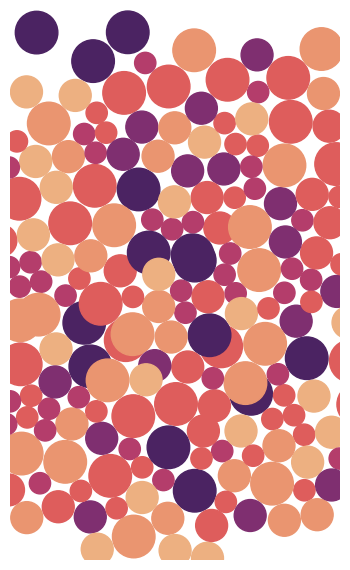

In [19]:

scatter_heights(items, xy_new, df_inventory, dims, 6)

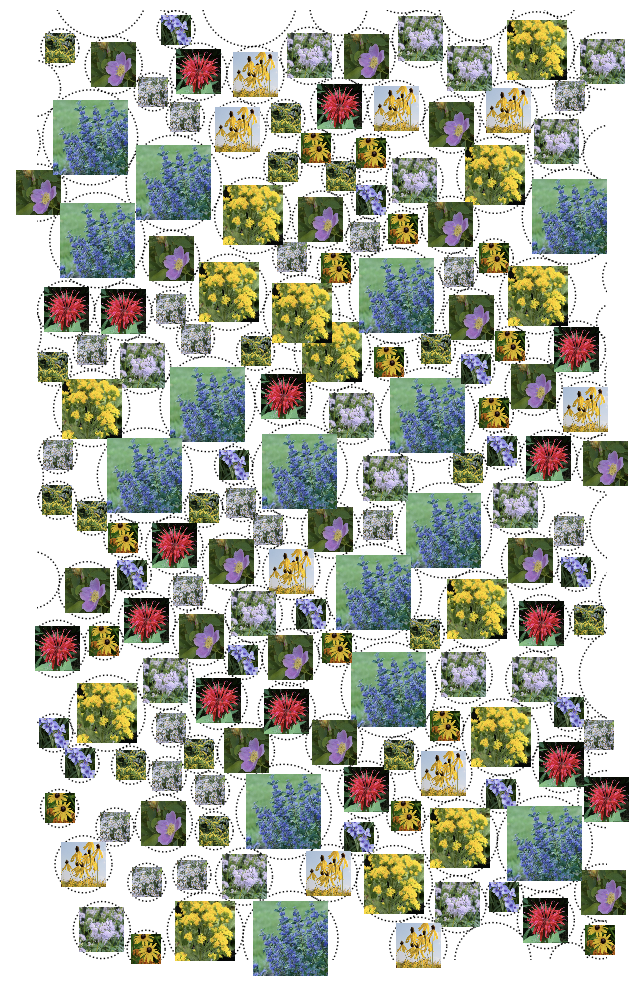

In [122]:
plot_garden(items, xy_new, df_inventory, dims, figsize=10, plot_sideview=False)